# Import Library

In [1]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
import tensorflow as tf
from sklearn.metrics import classification_report
import os
import numpy as np
import pandas as pd

# Data Understanding

In [2]:
base_dir = 'E:/Godentist Dataset Capstone/Dataset Clear/data_set/tampak_atas'

In [3]:
print(os.listdir(base_dir))

['Bengkak Gusi', 'Bukan Gambar Gigi', 'Gigi Berlubang', 'Gigi Sehat', 'Plak Gigi']


In [4]:
# Menghitung jumlah gambar pada dataset
number_label = {}
total_files = 0
for i in os.listdir(base_dir):
    counting = len(os.listdir(os.path.join(base_dir, i)))
    number_label[i] = counting
    total_files += counting

print("Total Files : " + str(total_files))

Total Files : 2942


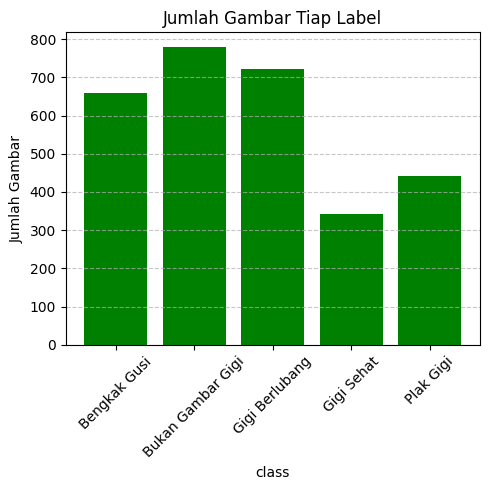

In [5]:
# Membuat plot dengan warna hijau
plt.figure(figsize=(5, 5))
plt.bar(number_label.keys(), number_label.values(), color='green')
plt.title("Jumlah Gambar Tiap Label")
plt.xlabel('class')
plt.ylabel('Jumlah Gambar')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

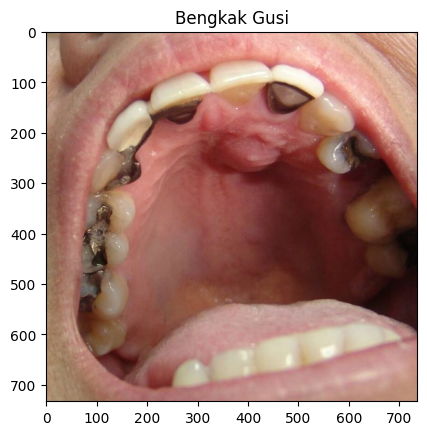

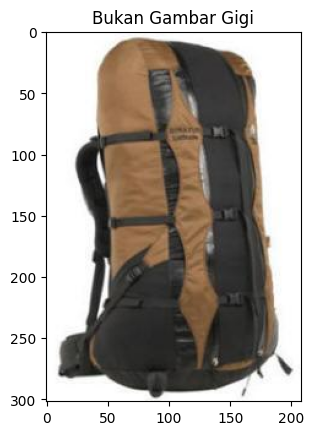

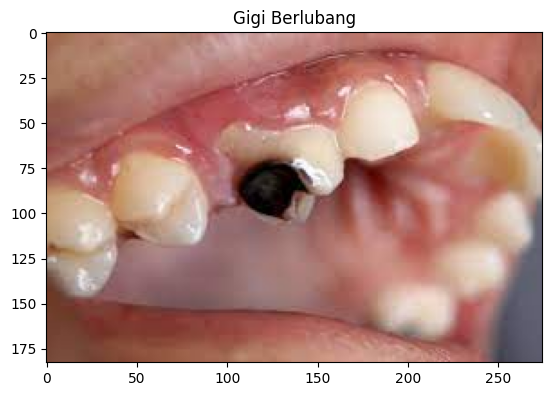

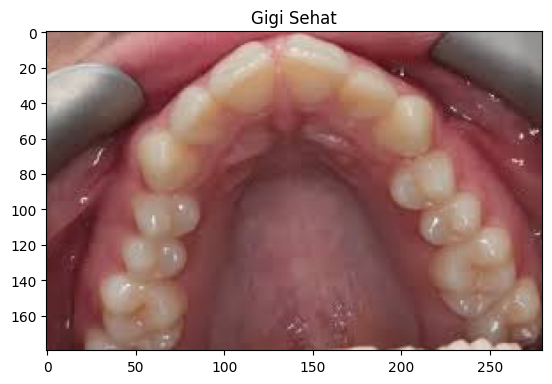

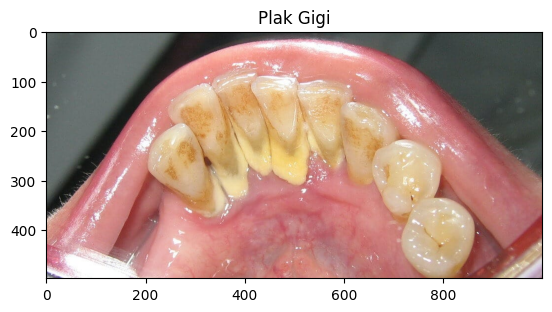

In [6]:
# Menampilkan sampel gambar tiap kelas
import matplotlib.image as mpimg

img_each_class = 1
img_samples = {}
classes = list(number_label.keys())


for c in classes:
    temp = os.listdir(os.path.join(base_dir, c))[:img_each_class]
    for item in temp:
        img_path = os.path.join(base_dir, c, item)
        img_samples[c] = img_path

for i in img_samples:
    fig = plt.gcf()
    img = mpimg.imread(img_samples[i])
    plt.title(i)
    plt.imshow(img)
    plt.show()

# Data Preparation

In [4]:
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 64
SEED = 999

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(validation_split=0.4,
                             rescale=1./255.,
                             rotation_range=20,
                             fill_mode = 'nearest')
#test_datagen = ImageDataGenerator(rescale = 1./255.)

In [11]:
#datagen = tf.keras.preprocessing.image.ImageDataGenerator(validation_split=0.2)

In [9]:
# Menyiapkan data train dan data validation
train_data = datagen.flow_from_directory(
    base_dir,
    class_mode='categorical',
    subset='training',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    seed=SEED
)

valid_data = datagen.flow_from_directory(
    base_dir,
    class_mode='categorical',
    subset='validation',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    seed=SEED 
)

Found 1766 images belonging to 5 classes.
Found 1173 images belonging to 5 classes.


In [ ]:
# Image Augmentation
'''data_augmentation = tf.keras.Sequential(
  [
    tf.keras.layers.RandomFlip("horizontal",input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
  ]
)

# Tambahkan lapisan Rescaling terpisah
data_augmentation.add(tf.keras.layers.Rescaling(1./255))
'''

# Transfer Learning Using Xception

In [10]:
from keras.applications import Xception
from tensorflow.keras import layers, models, optimizers, callbacks, regularizers

In [11]:
base_model = Xception(include_top=False, weights='imagenet', pooling='max', input_shape=(224, 224, 3))

base_model.trainable = False

In [12]:
xception_model = tf.keras.models.Sequential([
    
    base_model,
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256,activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1,activation='softmax'),
])

xception_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 5)                 1285      
                                                                 
Total params: 21,387,309
Trainable params: 525,829
Non-trainable params: 20,861,480
_________________________________________________________________


In [13]:
xception_model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy'])

In [14]:
callbacks_list = [
    callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    callbacks.ModelCheckpoint(filepath='best_model.keras', monitor='val_loss', save_best_only=True),
    callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)
]

In [15]:
xception_hist = xception_model.fit(
    train_data,
    epochs=50,
    validation_data = valid_data,
    callbacks = callbacks_list
   )

Epoch 1/50
28/28 [==============================] - 200s 7s/step - loss: 1.6701 - accuracy: 0.5306 - val_loss: 0.6701 - val_accuracy: 0.7835 - lr: 0.0010
Epoch 2/50
28/28 [==============================] - 184s 7s/step - loss: 0.6948 - accuracy: 0.7254 - val_loss: 0.5220 - val_accuracy: 0.8124 - lr: 0.0010
Epoch 3/50
28/28 [==============================] - 177s 6s/step - loss: 0.5940 - accuracy: 0.7865 - val_loss: 0.5159 - val_accuracy: 0.8321 - lr: 0.0010
Epoch 4/50
28/28 [==============================] - 175s 6s/step - loss: 0.5238 - accuracy: 0.8109 - val_loss: 0.4574 - val_accuracy: 0.8406 - lr: 0.0010
Epoch 5/50
28/28 [==============================] - 171s 6s/step - loss: 0.5102 - accuracy: 0.8018 - val_loss: 0.4405 - val_accuracy: 0.8593 - lr: 0.0010
Epoch 6/50
28/28 [==============================] - 166s 6s/step - loss: 0.4517 - accuracy: 0.8279 - val_loss: 0.4152 - val_accuracy: 0.8585 - lr: 0.0010
Epoch 7/50
28/28 [==============================] - 166s 6s/step - loss: 0.3

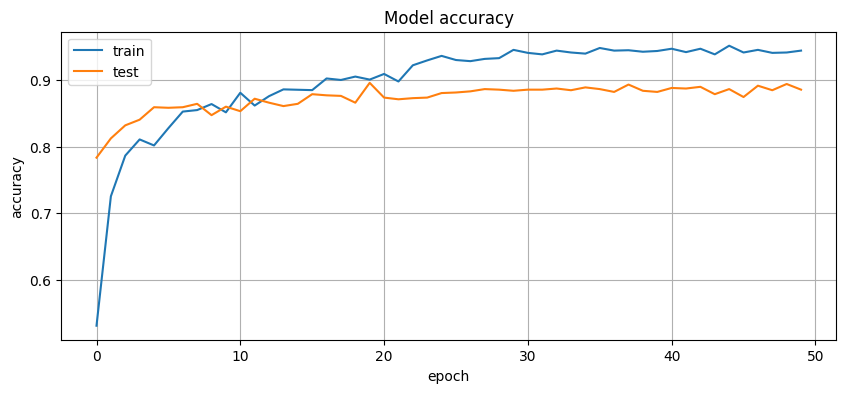

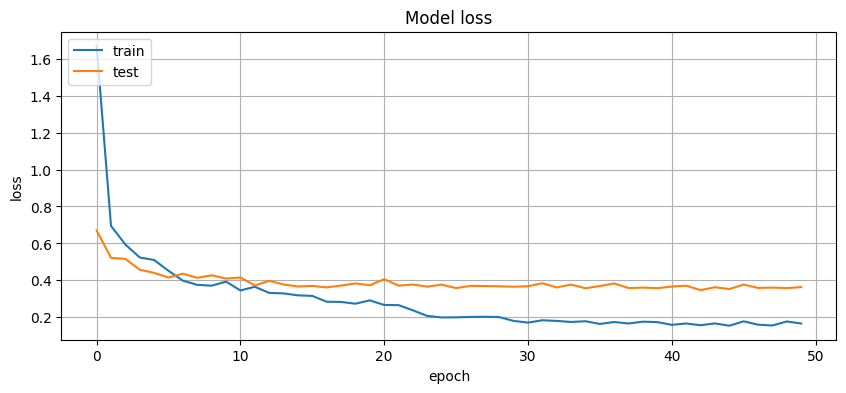

In [16]:
# Membuat plot akurasi model
plt.figure(figsize=(10,4))
plt.plot(xception_hist.history['accuracy'])
plt.plot(xception_hist.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid(True)
plt.show()

print()

# Membuat plot loss model
plt.figure(figsize=(10,4))
plt.plot(xception_hist.history['loss'])
plt.plot(xception_hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid(True)
plt.show()

In [17]:
# Evaluasi model pada data validasi
evaluation = xception_model.evaluate(valid_data)

# Menampilkan hasil evaluasi
print("Loss:", evaluation[0])
print("Accuracy:", evaluation[1])

19/19 [==============================] - 63s 3s/step - loss: 0.3854 - accuracy: 0.8849
Loss: 0.38542115688323975
Accuracy: 0.8849104642868042


In [18]:
# save model
xception_model.save('xception history 2_model.h5')  # Simpan model dalam format .h5